# TFIDF, WORD2VEC, DOC2VEC

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b

In [15]:
import numpy as np
import pandas as pd

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
#import tweepy as tw #for accessing Twitter API

# For Building the model
from sklearn.model_selection import train_test_split
#import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Read and clean data

In [17]:
df = pd.read_csv("data/Reddit_Data.csv")
df = df.rename(columns={'clean_comment':'text', 'category':'score'})
df.head(10)

,text,score
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
5,you should all sit down together and watch the...,-1
6,was teens when discovered zen meditation was ...,1
7,jesus was zen meets jew,0
8,there are two varieties christians dogmatic th...,-1
9,dont worry about trying explain yourself just ...,1


In [18]:
def score2label(score):
    return {-1:0, 0:2, 1:1}[score]

def score2sentiment(score):
    return {-1:"negative", 0:"neutral", 1:"positive"}[score] 

def label2sentiment(label):
    return {0:"negative", 2:"neutral", 1:"positive"}[score]

def label2score(label):
    return {0:-1, 1:1, 2:0}[label]

In [19]:
df.describe().loc["count"]

score    37249.0
Name: count, dtype: float64

In [20]:
df.isnull().sum() #100 adat hiányzik

text     100
score      0
dtype: int64

In [21]:
df.dropna(axis=0, inplace=True) #NA adatok eldobása

In [22]:
df.shape

(37149, 2)

# Insights

In [23]:
df.groupby("score")["text"].count()

score
-1     8277
 0    13042
 1    15830
Name: text, dtype: int64

In [24]:
df["label"] = list(map(score2label, df["score"]))
df["sentiment"] = list(map(score2sentiment, df["score"]))

df.head(10)

,text,score,label,sentiment
0,family mormon have never tried explain them t...,1,1,positive
1,buddhism has very much lot compatible with chr...,1,1,positive
2,seriously don say thing first all they won get...,-1,0,negative
3,what you have learned yours and only yours wha...,0,2,neutral
4,for your own benefit you may want read living ...,1,1,positive
5,you should all sit down together and watch the...,-1,0,negative
6,was teens when discovered zen meditation was ...,1,1,positive
7,jesus was zen meets jew,0,2,neutral
8,there are two varieties christians dogmatic th...,-1,0,negative
9,dont worry about trying explain yourself just ...,1,1,positive


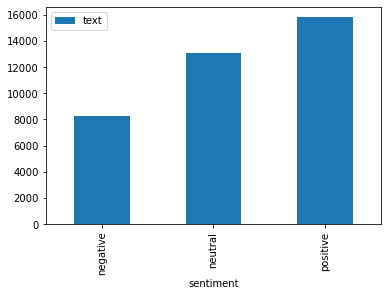

In [11]:
df.drop(columns=["score","label"]).groupby("sentiment").count().plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2a7c2a4f0>,
      dtype=object)

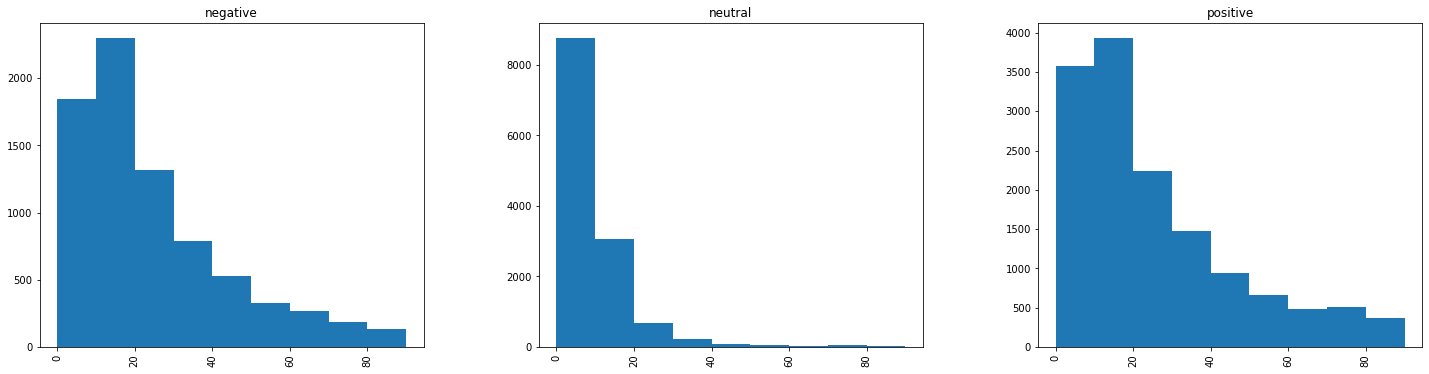

In [12]:
df["length"] = df.text.str.split().apply(len) #get num of words of text

df["length"].hist(by=df["sentiment"], bins=range(0,100,10), layout=(1,3), figsize=(24,6))

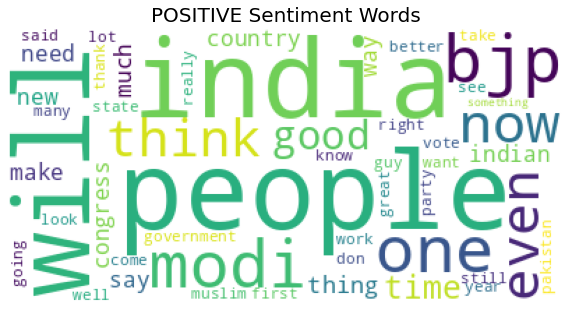

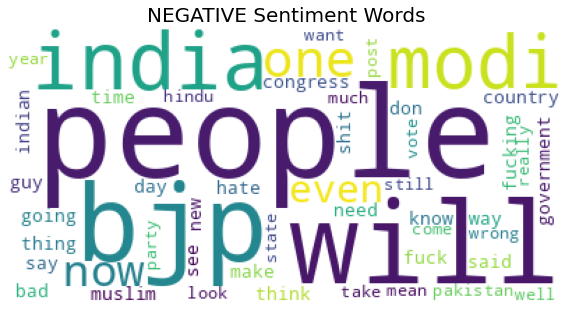

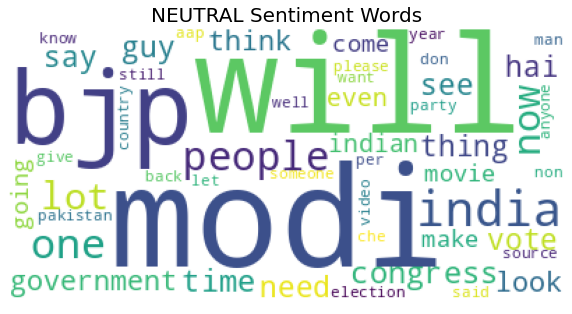

In [14]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.sentiment==category]['text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,6))
    plt.imshow(wc.generate(combined_tweets))
    title = '{} Sentiment Words'.format(category.upper())
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.savefig("figs/%s"%title)
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'positive')
     
# Negative tweet words
wordcount_gen(df, 'negative')
     
# Neutral tweet words
wordcount_gen(df, 'neutral')

# Text preprocessing

In [25]:
#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/nomino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nomino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
my_stopwords = stopwords.words("english")

In [27]:
def text_preprocess(text):
    ''' Convert tweet text into a sequence of words '''
    # convert to lowercase
    text = text.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in my_stopwords]
    # apply stemming
    words = [stemmer.stem(w) for w in words]
    #apply lemmatize
    words = [lemmatizer.lemmatize(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['text'][0])
print("\nProcessed tweet ->", text_preprocess(df['text'][0]))


Original tweet ->  family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches 

Processed tweet -> ['famili', 'mormon', 'never', 'tri', 'explain', 'still', 'stare', 'puzzl', 'time', 'time', 'like', 'kind', 'strang', 'creatur', 'nonetheless', 'come', 'admir', 'patienc', 'calm', 'equanim', 'accept', 'compass', 'develop', 'thing', 'buddhism', 'teach']


In [28]:
X = list(map(text_preprocess, df["text"]))

In [29]:
Y = list(df["label"])

In [30]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3, random_state=1)

# Evaluate embeddings

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score, matthews_corrcoef

In [33]:
def calculate_metrics(y, y_proba):
    y_pred = np.argmax(y_proba, axis=1)
    print(confusion_matrix(y, y_pred))
    multiclass = len(set(y)) > 2
    average = "macro" if multiclass else "binary"
    metrics = {
        "acc": accuracy_score(y, y_pred),
        "f1": f1_score(y, y_pred, average=average),
        "auc": roc_auc_score(y, y_proba, multi_class="ovo") if multiclass else roc_auc_score(y, y_pred)
    }
    print(metrics)
    return metrics

In [34]:
def evaluate_split(X_train, y_train, X_test, y_test, model=LogisticRegression()):
    results = {}
    model = model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_train)
    results["train"] = calculate_metrics(y_train, y_proba)
    y_proba = model.predict_proba(X_test)
    results["test"] = calculate_metrics(y_test, y_proba)
    return results

In [35]:
def metrics2df(results, columns=["dimension", "part", "metric", "score"]):
    records = []
    for dim in results:
        for part in results[dim]:
            for metric in results[dim][part]:
                score = results[dim][part][metric]
                records.append([dim, part, metric, score])
    return pd.DataFrame(records, columns=columns)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_heatmap(metrics_df, part="test", title=None, fsize=(8,4)):
    tmp_df = metrics_df[metrics_df["part"]==part]
    pivot_df = tmp_df.pivot(index="dimension", columns="metric", values="score")    
    fig, ax = plt.subplots(1,1,figsize=fsize)
    sns.heatmap(pivot_df, cmap='RdYlGn', annot=True, fmt=".3", ax=ax)#, vmin=0.5, vmax=1.0)
    if title is not None:
        plt.title(title)
    return fig
    
def train_test_performance(metrics_df, title=None, x_axis="dimension", hue="metric", fsize=(6,4)):
    tmp_df = metrics_df#[metrics_df["metric"]==metric]
    fig, ax = plt.subplots(1,1,figsize=fsize)
    if title != None:
        plt.title(title)
    sns.lineplot(data=tmp_df, x=x_axis, y="score", hue=hue, style="part", ax=ax, markers=True, err_style="bars")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

## Embedding tools

In [37]:
from operator import itemgetter
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
from gensim.models.word2vec import Word2Vec

In [39]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [40]:
def w2v_infer_vector(model, sentence):
    keys = [w for w in sentence if w in model.wv]
    if len(keys) > 0:
        return np.mean(model.wv[keys], axis=0)
    else:
        return np.zeros(model.vector_size)

# TF-IDF

In [41]:
def evaluate_tfidf(X_train, y_train, X_test, y_test, dims=[100,250,500,1000,2000,5000], model=LogisticRegression()):
    X_tr = np.array([' '.join(words) for words in X_train])
    X_te = np.array([' '.join(words) for words in X_test])
    results = {}
    for dim in dims:
        print(dim)
        vectorizer = TfidfVectorizer(max_features=dim)
        X_train = vectorizer.fit_transform(X_tr).toarray()
        X_test = vectorizer.transform(X_te).toarray()
        results[dim] = evaluate_split(X_train, y_train, X_test, y_test)
    return metrics2df(results)

In [63]:
metrics_df = evaluate_tfidf(X_tr, y_tr, X_te, y_te)

100
[[1254 2632 1918]
 [ 455 7867 2811]
 [ 193 1444 7430]]
{'acc': 0.6364790032302723, 'f1': 0.5691264738907432, 'auc': 0.7783351749162722}
[[ 537 1166  770]
 [ 203 3274 1220]
 [  66  624 3285]]
{'acc': 0.6366980708838044, 'f1': 0.5695473535136034, 'auc': 0.7781827817206178}
250


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2166 1817 1821]
 [ 667 8238 2228]
 [ 245  748 8074]]
{'acc': 0.7105829872327334, 'f1': 0.6669598851409521, 'auc': 0.8390579124099501}
[[ 891  846  736]
 [ 273 3432  992]
 [ 113  301 3561]]
{'acc': 0.7074024226110364, 'f1': 0.6613188367328243, 'auc': 0.8327170662866078}
500


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2853 1532 1419]
 [ 717 8602 1814]
 [ 193  571 8303]]
{'acc': 0.7598061836640517, 'f1': 0.7300751395636557, 'auc': 0.8787829823314084}
[[1146  763  564]
 [ 324 3556  817]
 [  93  250 3632]]
{'acc': 0.7477792732166891, 'f1': 0.7145383093141785, 'auc': 0.8649731785251319}
1000


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3534 1250 1020]
 [ 583 9291 1259]
 [ 180  418 8469]]
{'acc': 0.8188740193816336, 'f1': 0.7985528737473774, 'auc': 0.9230830088738614}
[[1428  617  428]
 [ 308 3800  589]
 [  78  223 3674]]
{'acc': 0.7987438313144908, 'f1': 0.7760258199025603, 'auc': 0.9027360654804064}
2000


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4037  999  768]
 [ 465 9765  903]
 [ 144  346 8577]]
{'acc': 0.8605983694816182, 'f1': 0.8462595549213642, 'auc': 0.9541152630999186}
[[1546  565  362]
 [ 254 3982  461]
 [  74  196 3705]]
{'acc': 0.8284432480933154, 'f1': 0.8087987822170106, 'auc': 0.9280196039127319}
5000


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 4224   861   719]
 [  356 10019   758]
 [  129   297  8641]]
{'acc': 0.8800184586986618, 'f1': 0.8675155687454298, 'auc': 0.9693785617884759}
[[1530  569  374]
 [ 237 3979  481]
 [  74  206 3695]]
{'acc': 0.8258411843876178, 'f1': 0.806069322233432, 'auc': 0.9340793245368673}


In [ ]:
fig = train_test_performance(metrics_df, "TfIdf performance")
#fig.savefig("figs/tfidf", bbox_inches='tight')

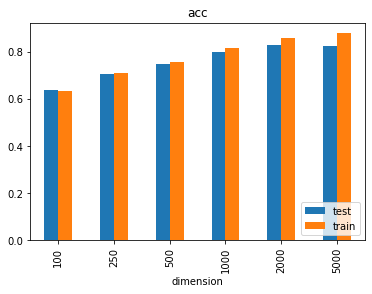

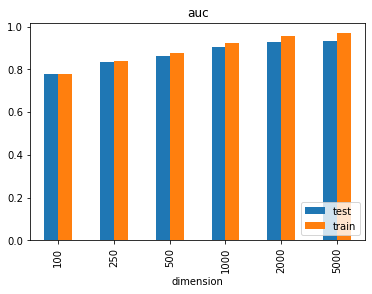

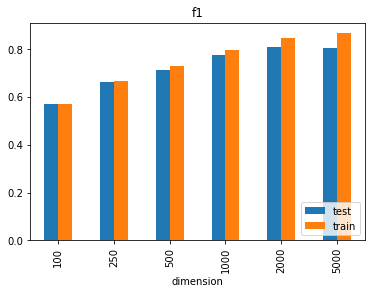

In [72]:
for metric in set(metrics_df["metric"]):
    pivot = metrics_df[metrics_df["metric"]==metric].groupby(["dimension","part"]).mean().unstack()
    pivot.columns = pivot.columns.droplevel()
    ax = pivot.plot(kind="bar", title=metric)
    ax.legend(loc='lower right')
    fig = ax.get_figure()
    fig.savefig("figs/tfidf_hist_%s"%metric)

## Test 

In [58]:
X_train = np.array([' '.join(words) for words in X_tr])
X_test = np.array([' '.join(words) for words in X_te])
print(X_train.shape, X_test.shape)

(26004,) (11145,)


In [59]:
dim = 2000
vectorizer = TfidfVectorizer(max_features=dim)

In [60]:
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
y_train = y_tr
y_test = y_te

In [61]:
vocab = vectorizer.vocabulary_

In [62]:
vocab.items()

dict_items([('loss', 1096), ('win', 1960), ('bjp', 232), ('greatest', 811), ('congress', 396), ('come', 364), ('second', 1594), ('almost', 83), ('local', 1082), ('elect', 601), ('made', 1106), ('vote', 1923), ('share', 1624), ('around', 140), ('take', 1780), ('next', 1239), ('major', 1112), ('give', 786), ('seriou', 1615), ('competit', 378), ('soon', 1689), ('recent', 1478), ('start', 1719), ('talk', 1782), ('muslim', 1210), ('appeas', 126), ('well', 1945), ('also', 87), ('speak', 1697), ('illeg', 910), ('actual', 42), ('promot', 1407), ('rule', 1555), ('gotta', 802), ('stay', 1725), ('relev', 1501), ('state', 1720), ('know', 1020), ('offici', 1267), ('poll', 1359), ('chanc', 320), ('voter', 1924), ('liter', 1075), ('educ', 595), ('funni', 766), ('even', 636), ('indian', 933), ('fan', 689), ('sure', 1767), ('noth', 1251), ('quit', 1436), ('like', 1069), ('watch', 1933), ('complet', 380), ('shit', 1628), ('post', 1367), ('receiv', 1477), ('gold', 795), ('first', 723), ('thought', 1816),

In [65]:
sorted(vocab.items(), key=itemgetter(1), reverse=True)[:10]

[('zero', 1999),
 ('yra', 1998),
 ('youtub', 1997),
 ('youth', 1996),
 ('young', 1995),
 ('yogi', 1994),
 ('yet', 1993),
 ('yesterday', 1992),
 ('yeh', 1991),
 ('year', 1990)]

# Word2Vec

In [53]:
def evaluate_word2vec(X_tr, y_train, X_te, y_test, dims=[20,50,100,250,500], model=LogisticRegression()):
    results = {}
    for dim in dims:
        print(dim)
        embedder = Word2Vec(X_tr, vector_size=dim)
        X_train = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_tr]
        X_test = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_te]
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        results[dim] = evaluate_split(X_train, y_train, X_test, y_test)
    return metrics2df(results)

In [ ]:
mdf = evaluate_word2vec(X_tr, y_tr, X_te, y_te)

In [ ]:
fig = train_test_performance(mdf, "Word2Vec performance")
#fig.savefig("figs/word2vec", bbox_inches='tight')

## Test

In [ ]:
dim=100
window=5
min_count=1
workers=2

In [ ]:
embedder = Word2Vec(X_tr, vector_size=dim, 
                    window=window, 
                    min_count=min_count, 
                    workers=workers)

In [ ]:
X_train = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_tr]
X_test = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_te]

X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape, X_test.shape)

# Doc2Vec

In [54]:
def metrics2df_doc2vec(results):
    records = []
    for dim in results:
        for epoch in results[dim]: 
            for part in results[dim][epoch]:
                for metric in results[dim][epoch][part]:
                    score = results[dim][epoch][part][metric]
                    records.append([dim, epoch, part, metric, score])
    return pd.DataFrame(records, columns=["dimension", "epochs", "part", "metric", "score"])

In [55]:
def evaluate_doc2vec(X_tr, y_train, X_te, y_test, dims=[20,50,100,200], epochs=[1,5,10,20], model=LogisticRegression()):
    results = {}
    for dim in dims:
        print(dim)
        tagged_doc = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(X_tr)]
        results[dim] = {}
        for epoch in epochs:
            print(epoch)
            embedder = Doc2Vec(tagged_doc, vector_size=dim, epochs=5)#, window=window, min_count=min_count, epochs=epochs, workers=workers)
            X_train = [list(embedder.infer_vector(sentence)) for sentence in X_tr]
            X_test = [list(embedder.infer_vector(sentence)) for sentence in X_te]
            X_train = np.array(X_train)
            X_test = np.array(X_test)
            results[dim].update({epoch: evaluate_split(X_train, y_train, X_test, y_test)})
    return metrics2df_doc2vec(results)

In [ ]:
mdf = evaluate_doc2vec(X_tr, y_tr, X_te, y_te)

In [ ]:
mdf['dimension'] = mdf['dimension'].astype('category')

In [ ]:
for metric in set(mdf["metric"]):
    fig = train_test_performance(mdf[mdf["metric"]==metric], x_axis="epochs", hue="dimension",  title="Doc2Vec %s"%metric)
    fig.savefig("figs/doc2vec_%s"%metric, bbox_inches="tight")

## Test

In [ ]:
tagged_doc = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(X_tr)]
embedder = Doc2Vec(tagged_doc, vector_size=dim, window=window, min_count=min_count, epochs=epochs, workers=workers)

In [ ]:
X_train = [list(embedder.infer_vector(sentence)) for sentence in X_tr]
X_test = [list(embedder.infer_vector(sentence)) for sentence in X_te]

X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape, X_test.shape)

# Evaluate

In [56]:
from sklearn.metrics import classification_report

In [66]:
model = LogisticRegression()
model = model.fit(X_train, y_train)
y_tr_pred = model.predict(X_train)
print(classification_report(y_tr_pred, y_train))
y_te_pred = model.predict(X_test)
print(classification_report(y_te_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.87      0.77      4646
           1       0.88      0.88      0.88     11110
           2       0.95      0.84      0.89     10248

    accuracy                           0.86     26004
   macro avg       0.84      0.86      0.85     26004
weighted avg       0.87      0.86      0.86     26004

              precision    recall  f1-score   support

           0       0.63      0.82      0.71      1874
           1       0.85      0.84      0.84      4743
           2       0.93      0.82      0.87      4528

    accuracy                           0.83     11145
   macro avg       0.80      0.83      0.81     11145
weighted avg       0.84      0.83      0.83     11145



/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Drop neutral

In [67]:
from itertools import compress

In [68]:
idx = np.array(y_tr) != 2
X_drop = list(compress(X_tr, idx))
print(len(X_tr), len(X_drop))
X_tfidf = np.array([' '.join(words) for words in X_drop])
X_tfidf.shape

26004 16937


(16937,)

In [69]:
def generate_embedding(X_train, X_test, embedding, config):
    if embedding == "tfidf":
        X_train = np.array([' '.join(words) for words in X_train])
        X_test = np.array([' '.join(words) for words in X_test])
        vectorizer = TfidfVectorizer(max_features=config["dim"])
        X_train = vectorizer.fit_transform(X_train).toarray()
        X_test = vectorizer.transform(X_test).toarray()
    elif embedding in ["word2vec", "doc2vec"]:
        if embedding == "word2vec":
            embedder = Word2Vec(X_train, vector_size=config["dim"])
            X_train = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_train]
            X_test = [list(w2v_infer_vector(embedder, sentence)) for sentence in X_test]
        else:
            tagged_doc = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(X_train)]
            embedder = Doc2Vec(tagged_doc, vector_size=config["dim"], epochs=config["epoch"])
            X_train = [list(embedder.infer_vector(sentence)) for sentence in X_train]
            X_test = [list(embedder.infer_vector(sentence)) for sentence in X_test]
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    else:
        pass
    return X_train, X_test

In [70]:
def neutral_split(X_tr, y_tr, X_te, y_te, config):
    neutral_label = score2label(0)
    tr_idx = np.array(y_tr) != neutral_label
    te_idx = np.array(y_te) != neutral_label
    results = {}
    for embedding in config:
        print(embedding.upper())
        model = config[embedding]["model"]
        dim = config[embedding]["dim"]
        print("\tmulticlass".upper())
        X_train, X_test = generate_embedding(X_tr, X_te, embedding, config[embedding])
        metrics = evaluate_split(X_train, y_tr, X_test, y_te)
        results[embedding] = {"multiclass": metrics["test"]}
        # drop neutral
        print("\tbinary: drop neutral".upper())
        X_train, y_train = list(compress(X_train, tr_idx)), list(compress(y_tr, tr_idx))
        X_test, y_test = list(compress(X_test, te_idx)), list(compress(y_te, te_idx))
        metrics = evaluate_split(X_train, y_train, X_test, y_test)
        results[embedding].update({"binary": metrics["test"]})
    return results

In [71]:
config = {"tfidf": {"dim": 2000, "model": LogisticRegression()},
          "word2vec": {"dim": 50, "model": LogisticRegression()},
          "doc2vec": {"dim": 50, "epoch": 5, "model": LogisticRegression()}
         }

In [30]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3, random_state=1)

## Single time

In [72]:
results = neutral_split(X_tr, y_tr, X_te, y_te, config)

TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4037  999  768]
 [ 465 9765  903]
 [ 144  346 8577]]
{'acc': 0.8605983694816182, 'f1': 0.8462595549213642, 'auc': 0.9541152630999186}
[[1546  565  362]
 [ 254 3982  461]
 [  74  196 3705]]
{'acc': 0.8284432480933154, 'f1': 0.8087987822170106, 'auc': 0.9280196039127319}
	BINARY: DROP NEUTRAL
[[ 4170  1634]
 [  469 10664]]
{'acc': 0.8758339729586113, 'f1': 0.9102471085314326, 'auc': 0.838171505442342}
[[1575  898]
 [ 279 4418]]
{'acc': 0.8358437935843793, 'f1': 0.8824528113452512, 'auc': 0.7887393343532764}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1010 3401 1393]
 [ 356 8825 1952]
 [ 474 3173 5420]]
{'acc': 0.5866405168435626, 'f1': 0.5124633004389194, 'auc': 0.7350748355791756}
[[ 437 1472  564]
 [ 143 3763  791]
 [ 209 1457 2309]]
{'acc': 0.5840287124270973, 'f1': 0.5110920789523559, 'auc': 0.7315749919985857}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1378  4426]
 [  670 10463]]
{'acc': 0.69912026923304, 'f1': 0.8041657059411268, 'auc': 0.5886205123528977}
[[ 586 1887]
 [ 277 4420]]
{'acc': 0.6981868898186889, 'f1': 0.8033442384587424, 'auc': 0.5889926729220611}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 500 3312 1992]
 [ 303 7786 3044]
 [  31 4541 4495]]
{'acc': 0.4915013074911552, 'f1': 0.40522852281955773, 'auc': 0.6661395796686693}
[[ 210 1417  846]
 [ 130 3203 1364]
 [  19 1981 1975]]
{'acc': 0.48344549125168235, 'f1': 0.39979224052631146, 'auc': 0.6568452560923527}
	BINARY: DROP NEUTRAL
[[  409  5395]
 [  263 10870]]
{'acc': 0.6659384778886461, 'f1': 0.7934885758084533, 'auc': 0.5234225902676758}
[[ 180 2293]
 [ 122 4575]]
{'acc': 0.6631799163179917, 'f1': 0.7911802853437094, 'auc': 0.5234060318977424}


In [73]:
mdf = metrics2df(results, ["embedding", "part", "metric", "score"])
mdf

,embedding,part,metric,score
0,tfidf,multiclass,acc,0.828443
1,tfidf,multiclass,f1,0.808799
2,tfidf,multiclass,auc,0.928020
3,tfidf,binary,acc,0.835844
4,tfidf,binary,f1,0.882453
5,tfidf,binary,auc,0.788739
6,word2vec,multiclass,acc,0.584029
7,word2vec,multiclass,f1,0.511092
8,word2vec,multiclass,auc,0.731575
9,word2vec,binary,acc,0.698187


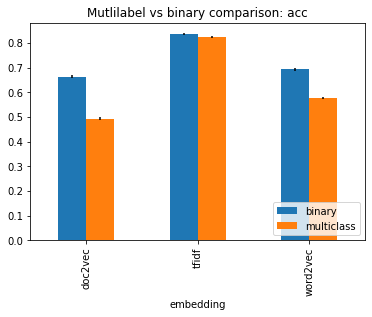

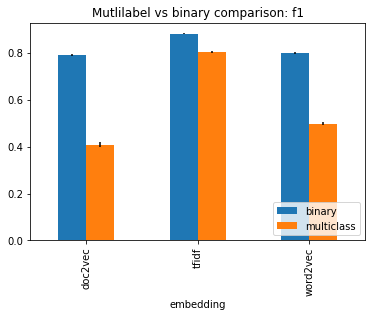

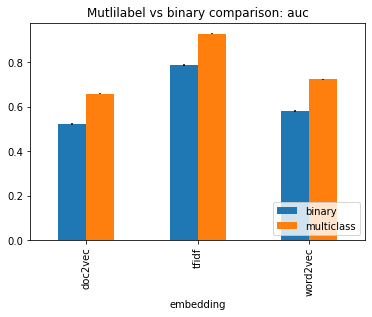

In [114]:
for metric in set(mdf["metric"]):
    pivot = mdf[mdf["metric"]==metric].groupby(["embedding","part"]).mean().unstack()
    pivot.columns = pivot.columns.droplevel()
    ax = pivot.plot(kind="bar", title=metric)
    ax.legend(loc='lower right')
    ax.set_title("Mutlilabel vs binary comparison: %s"%metric)
    fig = ax.get_figure()
    fig.savefig("figs/multi_binary_%s"%metric, bbox_inches="tight")

## Multiple times

In [ ]:
parts = []
for _ in range(5):
    print('\n\n%i EPOCH\n'%_)
    X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3)
    results = neutral_split(X_tr, y_tr, X_te, y_te, config)
    parts.append(metrics2df(results, ["embedding", "part", "metric", "score"]))

In [77]:
mdf = pd.concat(parts)
mdf

TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4033 1022  757]
 [ 449 9698  912]
 [ 153  343 8637]]
{'acc': 0.8601753576372866, 'f1': 0.8458292968917521, 'auc': 0.9543299995440356}
[[1566  520  379]
 [ 279 4017  475]
 [  75  181 3653]]
{'acc': 0.828712427097353, 'f1': 0.8096753532239577, 'auc': 0.9305972897199227}
	BINARY: DROP NEUTRAL
[[ 4157  1655]
 [  450 10609]]
{'acc': 0.8752296840732618, 'f1': 0.9097457445440124, 'auc': 0.8372767410262182}
[[1612  853]
 [ 299 4472]]
{'acc': 0.8407960199004975, 'f1': 0.8858954041204439, 'auc': 0.7956425377630145}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 944 3514 1354]
 [ 312 8687 2060]
 [ 411 3396 5326]]
{'acc': 0.5751807414243962, 'f1': 0.5000695491286387, 'auc': 0.7259570738598836}
[[ 406 1510  549]
 [ 139 3814  818]
 [ 195 1508 2206]]
{'acc': 0.5765814266487214, 'f1': 0.5001507409563571, 'auc': 0.7228135506216562}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1303  4509]
 [  583 10476]]
{'acc': 0.6981803094066742, 'f1': 0.804484718169252, 'auc': 0.5857370422062681}
[[ 548 1917]
 [ 246 4525]]
{'acc': 0.701077943615257, 'f1': 0.8070989030589494, 'auc': 0.5853754278617901}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 573 3299 1940]
 [ 327 7702 3030]
 [  31 4334 4768]]
{'acc': 0.5015766805106907, 'f1': 0.41963238238098666, 'auc': 0.6691458659522818}
[[ 246 1385  834]
 [ 121 3301 1349]
 [  10 1864 2035]]
{'acc': 0.5008524001794527, 'f1': 0.41902711914752916, 'auc': 0.6624895422364329}
	BINARY: DROP NEUTRAL
[[  418  5394]
 [  237 10822]]
{'acc': 0.6662319957323217, 'f1': 0.7935472043996333, 'auc': 0.525244828043939}
[[ 178 2287]
 [  97 4674]]
{'acc': 0.6705362078496406, 'f1': 0.7967950903511762, 'auc': 0.525939892938362}
TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3983 1019  728]
 [ 440 9745  940]
 [ 134  321 8694]]
{'acc': 0.8622519612367328, 'f1': 0.8476992178699295, 'auc': 0.9549638567170282}
[[1556  570  421]
 [ 261 3981  463]
 [  86  207 3600]]
{'acc': 0.8198295199641095, 'f1': 0.8000681026368204, 'auc': 0.929456358317892}
	BINARY: DROP NEUTRAL
[[ 4074  1656]
 [  428 10697]]
{'acc': 0.8763571640462771, 'f1': 0.9112360507709345, 'auc': 0.8362614271427731}
[[1611  936]
 [ 259 4446]]
{'acc': 0.8352178709321566, 'f1': 0.8815306830574006, 'auc': 0.7887305062278683}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 884 3429 1417]
 [ 359 8593 2173]
 [ 449 3191 5509]]
{'acc': 0.5762959544685433, 'f1': 0.4981733988988779, 'auc': 0.7254325825998226}
[[ 358 1536  653]
 [ 117 3735  853]
 [ 200 1388 2305]]
{'acc': 0.5740690892777031, 'f1': 0.4926505446322083, 'auc': 0.7230944072549365}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1257  4473]
 [  650 10475]]
{'acc': 0.69605458320973, 'f1': 0.803513212902236, 'auc': 0.5804723807282781}
[[ 538 2009]
 [ 232 4473]]
{'acc': 0.6909817981246553, 'f1': 0.7996781979082863, 'auc': 0.580959825628868}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 409 3347 1974]
 [ 308 7734 3083]
 [  34 4331 4784]]
{'acc': 0.49711582833410245, 'f1': 0.40431449784622475, 'auc': 0.6713736243469605}
[[ 191 1415  941]
 [ 110 3208 1387]
 [  12 1856 2025]]
{'acc': 0.4866756393001346, 'f1': 0.3994634458117338, 'auc': 0.6582985316868343}
	BINARY: DROP NEUTRAL
[[  334  5396]
 [  260 10865]]
{'acc': 0.6644319193117769, 'f1': 0.7934711166289345, 'auc': 0.5174594583995137}
[[ 176 2371]
 [  90 4615]]
{'acc': 0.6606453392167678, 'f1': 0.7894961936532375, 'auc': 0.5249861582065876}
TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4045 1026  741]
 [ 428 9753  915]
 [ 143  330 8623]]
{'acc': 0.8622135056145208, 'f1': 0.8481209541418506, 'auc': 0.9544538726801378}
[[1523  566  376]
 [ 268 4023  443]
 [  75  225 3646]]
{'acc': 0.824764468371467, 'f1': 0.804317093265646, 'auc': 0.92655206932147}
	BINARY: DROP NEUTRAL
[[ 4185  1627]
 [  430 10666]]
{'acc': 0.8783416134374261, 'f1': 0.9120526743340887, 'auc': 0.8406546185675562}
[[1542  923]
 [ 282 4452]]
{'acc': 0.8326156410612585, 'f1': 0.8807992877633791, 'auc': 0.7829943672762143}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 855 3526 1431]
 [ 315 8731 2050]
 [ 456 3370 5270]]
{'acc': 0.5712967235809875, 'f1': 0.4913068520099859, 'auc': 0.7199060900905065}
[[ 378 1526  561]
 [ 125 3765  844]
 [ 175 1553 2218]]
{'acc': 0.5707492148945715, 'f1': 0.49232689796129314, 'auc': 0.7185667729789635}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1251  4561]
 [  611 10485]]
{'acc': 0.6941092973740242, 'f1': 0.8021574477851732, 'auc': 0.5800897169221029}
[[ 535 1930]
 [ 265 4469]]
{'acc': 0.6950965411862758, 'f1': 0.802838408335579, 'auc': 0.580530254145275}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 571 3313 1928]
 [ 381 7777 2938]
 [  45 4561 4490]]
{'acc': 0.49369327795723733, 'f1': 0.41197015617223093, 'auc': 0.6643370782844442}
[[ 220 1413  832]
 [ 156 3311 1267]
 [  13 1990 1943]]
{'acc': 0.491161956034096, 'f1': 0.40636365177364503, 'auc': 0.6589167142288033}
	BINARY: DROP NEUTRAL
[[  522  5290]
 [  314 10782]]
{'acc': 0.6685592618878637, 'f1': 0.7937279151943463, 'auc': 0.530757845811391}
[[ 190 2275]
 [ 142 4592]]
{'acc': 0.6642589248506737, 'f1': 0.7916558917334714, 'auc': 0.5235416661310737}
TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4004  988  748]
 [ 435 9776  917]
 [ 131  374 8631]]
{'acc': 0.8618289493924012, 'f1': 0.8477200942676261, 'auc': 0.9548147522180243}
[[1513  576  448]
 [ 262 3981  459]
 [  66  163 3677]]
{'acc': 0.8228802153432032, 'f1': 0.8008074093313082, 'auc': 0.9290837143574041}
	BINARY: DROP NEUTRAL
[[ 4099  1641]
 [  444 10684]]
{'acc': 0.8763931705003557, 'f1': 0.9110987933313436, 'auc': 0.8371060726371873}
[[1592  945]
 [ 270 4432]]
{'acc': 0.8321591380024865, 'f1': 0.8794523266197044, 'auc': 0.7850452184739442}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1008 3323 1409]
 [ 336 8647 2145]
 [ 402 3172 5562]]
{'acc': 0.5851792031995078, 'f1': 0.5123625421311908, 'auc': 0.7345987106156153}
[[ 398 1530  609]
 [ 165 3727  810]
 [ 188 1403 2315]]
{'acc': 0.5778375953342306, 'f1': 0.501386623507027, 'auc': 0.7271680837016246}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1366  4374]
 [  617 10511]]
{'acc': 0.7041142992648802, 'f1': 0.8081343943412909, 'auc': 0.5912666857874289}
[[ 534 2003]
 [ 265 4437]]
{'acc': 0.6866970576046415, 'f1': 0.7964458804523425, 'auc': 0.5770629142120689}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 485 3334 1921]
 [ 318 7796 3014]
 [  24 4441 4671]]
{'acc': 0.49807721888940165, 'f1': 0.41005094037013184, 'auc': 0.6685204010839195}
[[ 179 1443  915]
 [ 115 3200 1387]
 [  15 1850 2041]]
{'acc': 0.48631673396141767, 'f1': 0.397440743675524, 'auc': 0.6544179572842038}
	BINARY: DROP NEUTRAL
[[  382  5358]
 [  240 10888]]
{'acc': 0.6681290016599478, 'f1': 0.7954993789727478, 'auc': 0.5224916524095918}
[[ 141 2396]
 [  93 4609]]
{'acc': 0.6561679790026247, 'f1': 0.7873921585376271, 'auc': 0.5178993180804988}
TFIDF
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3985 1021  736]
 [ 461 9707  922]
 [ 147  346 8679]]
{'acc': 0.8602907245039225, 'f1': 0.8456113532415199, 'auc': 0.9544873837624207}
[[1574  566  395]
 [ 253 4022  465]
 [  75  183 3612]]
{'acc': 0.8262000897263346, 'f1': 0.8070751061327376, 'auc': 0.9296450405194169}
	BINARY: DROP NEUTRAL
[[ 4088  1654]
 [  447 10643]]
{'acc': 0.8751782319391636, 'f1': 0.9101637661948947, 'auc': 0.83582023713394}
[[1599  936]
 [ 257 4483]]
{'acc': 0.8360137457044674, 'f1': 0.8825671818092332, 'auc': 0.7882749107432652}
WORD2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 984 3325 1433]
 [ 346 8622 2122]
 [ 452 3314 5406]]
{'acc': 0.5772958006460545, 'f1': 0.504073458892596, 'auc': 0.7288775880412665}
[[ 425 1542  568]
 [ 134 3771  835]
 [ 203 1408 2259]]
{'acc': 0.5791834903544191, 'f1': 0.5052361904302655, 'auc': 0.7267613871998586}
	BINARY: DROP NEUTRAL


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1365  4377]
 [  660 10430]]
{'acc': 0.7007485741444867, 'f1': 0.8054987064138703, 'auc': 0.5891044866123378}
[[ 570 1965]
 [ 268 4472]]
{'acc': 0.6930584192439863, 'f1': 0.8002147266708418, 'auc': 0.5841559933088657}
DOC2VEC
	MULTICLASS


/home/nomino/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 560 3170 2012]
 [ 360 7652 3078]
 [  49 4290 4833]]
{'acc': 0.5016535917551146, 'f1': 0.41905784822434017, 'auc': 0.6716105425947368}
[[ 244 1439  852]
 [ 149 3218 1373]
 [  16 1749 2105]]
{'acc': 0.49950650515926426, 'f1': 0.418867461103207, 'auc': 0.6638500127511925}
	BINARY: DROP NEUTRAL
[[  501  5241]
 [  316 10774]]
{'acc': 0.6698550380228137, 'f1': 0.7949824755580152, 'auc': 0.5293788448836488}
[[ 230 2305]
 [ 134 4606]]
{'acc': 0.6647422680412371, 'f1': 0.790661745772895, 'auc': 0.5312298704216913}


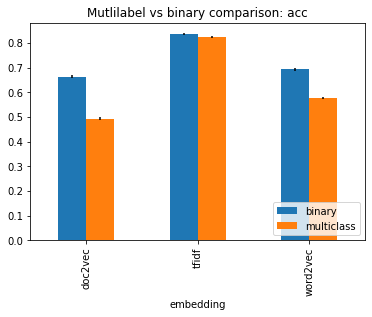

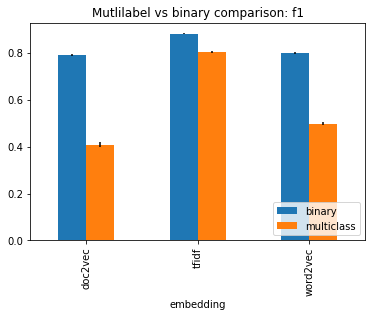

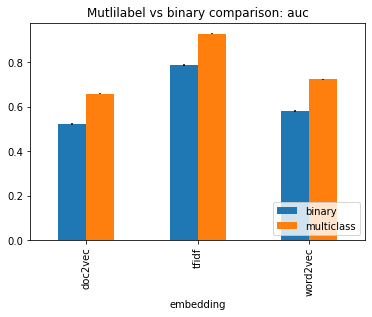

In [114]:
for metric in set(mdf["metric"]):
    pivot = mdf[mdf["metric"]==metric].groupby(["embedding","part"]).mean().unstack()
    pivot.columns = pivot.columns.droplevel()
    ax = pivot.plot(kind="bar", title=metric)
    ax.legend(loc='lower right')
    ax.set_title("Mutlilabel vs binary comparison: %s"%metric)
    fig = ax.get_figure()
    fig.savefig("figs/multi_binary_%s"%metric, bbox_inches="tight")